# Multivariate Multistep LSTM Extended Example

Based on:
* [Time Series Forecasting on Stock Prices](https://www.youtube.com/watch?v=j05UUs99eNQ) from [Coding Tech](https://www.youtube.com/channel/UCtxCXg-UvSnTKPOzLH4wJaQ)
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

**Disclaimer:** _Investing in the stock market involves risk and can lead to monetary loss. This material is purely for educational purposes and should not be taken as professional investment advice. Invest at your own discretion._

Import the libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import matplotlib.pyplot as plt

Load the data

In [2]:
df = pd.read_csv("SP500.csv")

Show the data

In [3]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,775500,0.0,0
1,2000-05-22,94.716551,94.716551,92.169162,94.190231,1850600,0.0,0
2,2000-05-23,94.463952,94.463952,92.758675,92.758675,373900,0.0,0
3,2000-05-24,92.800753,94.358660,92.063905,94.148132,400300,0.0,0
4,2000-05-25,94.337613,94.948145,92.884970,93.284973,69600,0.0,0
...,...,...,...,...,...,...,...,...
5359,2021-09-08,452.899994,453.679993,450.869995,453.000000,4076800,0.0,0
5360,2021-09-09,452.690002,454.579987,450.730011,450.980011,3851600,0.0,0
5361,2021-09-10,453.059998,453.510010,447.299988,447.540009,3023500,0.0,0
5362,2021-09-13,450.679993,450.929993,446.089996,448.579987,3007400,0.0,0


Add indices for every day in the period

In [4]:
start_date = df.Date.min()
end_date = df.Date.max()

In [5]:
df_date = pd.date_range(start=start_date, end=end_date).to_frame(name="Date")
df_date.reset_index(drop=True, inplace=True) 

In [6]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.merge(df_date, how='right')

Interpolate missing values

In [7]:
df = df.interpolate(method='linear', limit_direction='both')

Remove not needed columns

In [8]:
df = df[['Date', 'Close']].copy()

In [9]:
df

,Date,Close
0,2000-05-19,94.779701
1,2000-05-20,94.583211
2,2000-05-21,94.386721
3,2000-05-22,94.190231
4,2000-05-23,92.758675
...,...,...
7784,2021-09-10,447.540009
7785,2021-09-11,447.886668
7786,2021-09-12,448.233327
7787,2021-09-13,448.579987


**Simple Moving Average**
* Example periods: 15, 30 or 45 days

In [10]:
def computeSMA(data, period, column='Close'):
    return data[column].rolling(window=period).mean()

In [11]:
df['SMA'] = computeSMA(df, period=15)

**Exponential Moving Averages**
* Example periods: 15, 30 or 45 days

In [12]:
def computeEMA(data, period, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

In [13]:
df['EMA'] = computeEMA(df, period=15)

**Relative Strength Index**

In [14]:
def computeRSI(data, period=14, column='Close'):
    delta = data[column].diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    data['up'] = up
    data['down'] = down
    AVG_Gain = computeSMA(data, period, column='up')
    AVG_Loss = abs(computeSMA(data, period, column='down'))
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

In [15]:
df['RSI'] = computeRSI(df, period=14)

**Moving Average Convergence Divergence**

In [16]:
def MACD(data, period1=26, period2=12, signal=9, column='Close'):
    exp1 = computeEMA(data,period1, column=column)
    exp2 = computeEMA(data,period2, column=column)
    data['MACD'] = exp2 - exp1
    data['Signal Line'] = computeSMA(data, signal, column='MACD')

In [17]:
MACD(df)

Remove NaNs

In [18]:
df = df.dropna()

In [19]:
df

,Date,Close,SMA,EMA,up,down,RSI,MACD,Signal Line
14,2000-06-02,99.663971,94.910938,95.600925,1.936874,0.000000,71.245582,0.680463,-0.042866
15,2000-06-03,99.446431,95.222053,96.081613,0.000000,-0.217539,71.115354,0.916439,0.090681
16,2000-06-04,99.228892,95.531765,96.475023,0.000000,-0.217539,70.985601,1.073524,0.250695
17,2000-06-05,99.011353,95.840074,96.792064,0.000000,-0.217539,70.856321,1.167008,0.420929
18,2000-06-06,98.506065,96.127796,97.006314,0.000000,-0.505287,77.029581,1.186644,0.585988
...,...,...,...,...,...,...,...,...,...
7784,2021-09-10,447.540009,453.257671,451.878931,0.000000,-3.440002,30.279938,1.487905,2.619024
7785,2021-09-11,447.886668,452.970782,451.379898,0.346659,0.000000,28.313930,1.046934,2.394046
7786,2021-09-12,448.233327,452.662337,450.986577,0.346659,0.000000,26.233827,0.717167,2.129901
7787,2021-09-13,448.579987,452.332335,450.685753,0.346659,0.000000,24.029401,0.478284,1.844411


Convert series to supervised learning

In [20]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'var{j+1}(t-{i})') for j in range(n_vars)]

    # Forecast sequence
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'var{j+1}(t)') for j in range(n_vars)]
        else:
            names += [(f'var{j+1}(t+{i})') for j in range(n_vars)]
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

Define input sequence

In [21]:
dataset = df.drop(["Date","up", "down"], axis=1)
values = dataset.values

Normalize features

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Specify number of lag steps

In [23]:
n_days = 3
n_features = 6 # Close, SMA, EMA, RSI, MACD, Signal Line

Frame as supervised learning

In [24]:
reframed = series_to_supervised(scaled, n_days, 1)

In [25]:
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
3,0.115356,0.098279,0.099546,0.703972,0.750533,0.737481,0.114815,0.099061,0.100758,0.702632,...,0.101750,0.701296,0.763936,0.748528,0.113733,0.100616,0.102549,0.699965,0.767123,0.754934
4,0.114815,0.099061,0.100758,0.702632,0.758580,0.742507,0.114274,0.099841,0.101750,0.701296,...,0.102549,0.699965,0.767123,0.754934,0.112476,0.101340,0.103090,0.763519,0.767793,0.761145
5,0.114274,0.099841,0.101750,0.701296,0.763936,0.748528,0.113733,0.100616,0.102549,0.699965,...,0.103090,0.763519,0.767793,0.761145,0.114100,0.102414,0.103768,0.745909,0.769631,0.767096
6,0.113733,0.100616,0.102549,0.699965,0.767123,0.754934,0.112476,0.101340,0.103090,0.763519,...,0.103768,0.745909,0.769631,0.767096,0.113209,0.103194,0.104249,0.787632,0.769616,0.772401
7,0.112476,0.101340,0.103090,0.763519,0.767793,0.761145,0.114100,0.102414,0.103768,0.745909,...,0.104249,0.787632,0.769616,0.772401,0.112319,0.104059,0.104557,0.793172,0.768149,0.776930


Drop the columns not to be predicted

In [26]:
reframed.drop(reframed.columns[[19, 20, 21, 22, 23]], axis=1, inplace=True)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
3,0.115356,0.098279,0.099546,0.703972,0.750533,0.737481,0.114815,0.099061,0.100758,0.702632,0.758580,0.742507,0.114274,0.099841,0.101750,0.701296,0.763936,0.748528,0.113733
4,0.114815,0.099061,0.100758,0.702632,0.758580,0.742507,0.114274,0.099841,0.101750,0.701296,0.763936,0.748528,0.113733,0.100616,0.102549,0.699965,0.767123,0.754934,0.112476
5,0.114274,0.099841,0.101750,0.701296,0.763936,0.748528,0.113733,0.100616,0.102549,0.699965,0.767123,0.754934,0.112476,0.101340,0.103090,0.763519,0.767793,0.761145,0.114100
6,0.113733,0.100616,0.102549,0.699965,0.767123,0.754934,0.112476,0.101340,0.103090,0.763519,0.767793,0.761145,0.114100,0.102414,0.103768,0.745909,0.769631,0.767096,0.113209
7,0.112476,0.101340,0.103090,0.763519,0.767793,0.761145,0.114100,0.102414,0.103768,0.745909,0.769631,0.767096,0.113209,0.103194,0.104249,0.787632,0.769616,0.772401,0.112319


Split into train and test sets

In [27]:
values = reframed.values
n_train_days = values.shape[0]-n_features*n_days
train = values[:n_train_days, :]
test = values[n_train_days:, :]

Split into input and outputs

In [28]:
n_obs = n_days * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

Reshape input to be 3D [samples, timesteps, features]

In [29]:
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

In [30]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((7754, 3, 6), (7754,), (18, 3, 6), (18,))

Define model

In [31]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

In [32]:
model.compile(loss='mae', optimizer='adam')

Fit model

In [33]:
history = model.fit(train_X, train_y, 
                    epochs=100, batch_size=128, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

Epoch 1/100
61/61 - 0s - loss: 0.0640 - val_loss: 0.1126
Epoch 2/100
61/61 - 0s - loss: 0.0878 - val_loss: 0.0110
Epoch 3/100
61/61 - 0s - loss: 0.0613 - val_loss: 0.0141
Epoch 4/100
61/61 - 0s - loss: 0.0117 - val_loss: 0.0063
Epoch 5/100
61/61 - 0s - loss: 0.0071 - val_loss: 0.0058
Epoch 6/100
61/61 - 0s - loss: 0.0055 - val_loss: 0.0052
Epoch 7/100
61/61 - 0s - loss: 0.0058 - val_loss: 0.0050
Epoch 8/100
61/61 - 0s - loss: 0.0056 - val_loss: 0.0047
Epoch 9/100
61/61 - 0s - loss: 0.0052 - val_loss: 0.0046
Epoch 10/100
61/61 - 0s - loss: 0.0064 - val_loss: 0.0047
Epoch 11/100
61/61 - 0s - loss: 0.0062 - val_loss: 0.0053
Epoch 12/100
61/61 - 0s - loss: 0.0052 - val_loss: 0.0056
Epoch 13/100
61/61 - 0s - loss: 0.0071 - val_loss: 0.0097
Epoch 14/100
61/61 - 0s - loss: 0.0098 - val_loss: 0.0152
Epoch 15/100
61/61 - 0s - loss: 0.0269 - val_loss: 0.0183
Epoch 16/100
61/61 - 0s - loss: 0.0200 - val_loss: 0.0190
Epoch 17/100
61/61 - 0s - loss: 0.0261 - val_loss: 0.0074
Epoch 18/100
61/61 - 0s

Plot history

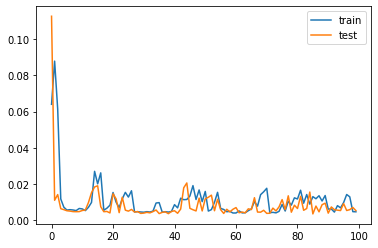

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Demonstrate training

In [35]:
yhat = model.predict(train_X)

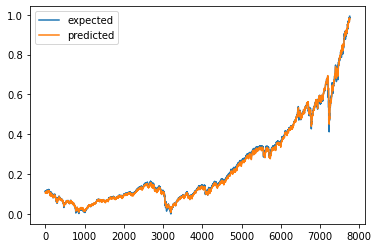

In [36]:
plt.plot(train_y, label='expected')
plt.plot(yhat, label='predicted')
plt.legend()
plt.show()

Demonstrate prediction

In [37]:
yhat = model.predict(test_X)

In [38]:
print(f"Predicted: {yhat[0][0]:.2f}  Expected: {test_y[0]:.2f}")

Predicted: 0.98  Expected: 0.99


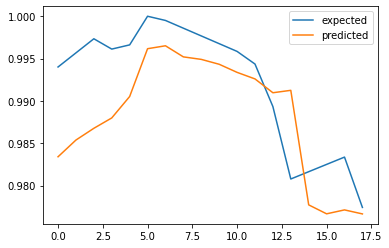

In [39]:
plt.plot(test_y, label='expected')
plt.plot(yhat, label='predicted')
plt.legend()
plt.show()

**THIS IS NOT AN INVESTMENT ADVICE!**